In [109]:
import data_query as dq
import importlib
importlib.reload(dq)  # Reloads without restarting kernel
# board_w_repair.csv -> for boards complete date(from manufacturing_serialnumber) after 2025 and exclude all-pass boards

<module 'data_query' from 'c:\\Users\\Le-Hao.Hsu\\OneDrive - Foxconn Industrial Internet in North America\\Desktop\\Gavin\\cims_test\\data_query.py'>

In [ ]:
# sn generated after 2024
df = dq.db_connect(dq.test_query)

# Percentage of Boards with No Repairs and Completed for Workorders Released After 2024

In [100]:
# Step 1: Count total unique serial numbers per (model_name, build_type, skuno)
total_sn = df.groupby(["model_name", "build_type", "skuno"])["serial_number"].nunique().reset_index()
total_sn.rename(columns={"serial_number": "total_sn"}, inplace=True)

# Step 2: Identify serial numbers where ALL test_result = 1
all_pass_sn = (
    df.groupby(["serial_number", "model_name", "build_type", "skuno"])["test_result"]
    .apply(lambda x: (x == 1).all())  # Check if all test results for a serial_number are 1
    .reset_index()
)

# Step 3: Count serial numbers where all test results are 1 per (model_name, build_type, skuno)
passed_sn = all_pass_sn[all_pass_sn["test_result"]].groupby(["model_name", "build_type", "skuno"])["serial_number"].nunique().reset_index()
passed_sn.rename(columns={"serial_number": "passed_sn"}, inplace=True)

# Step 4: Merge total_sn and passed_sn, fill missing values with 0
result_df = total_sn.merge(passed_sn, on=["model_name", "build_type", "skuno"], how="left").fillna(0)

# Step 5: Calculate pass percentage
result_df["pass_percentage"] = (result_df["passed_sn"] / result_df["total_sn"]) * 100

C:\Users\Le-Hao.Hsu\AppData\Local\Temp\ipykernel_24128\1027225764.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_data["x_labels"], rotation=45, ha="right", fontsize=8)
C:\Users\Le-Hao.Hsu\AppData\Local\Temp\ipykernel_24128\1027225764.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_data["x_labels"], rotation=45, ha="right", fontsize=8)
C:\Users\Le-Hao.Hsu\AppData\Local\Temp\ipykernel_24128\1027225764.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_data["x_labels"], rotation=45, ha="right", fontsize=8)


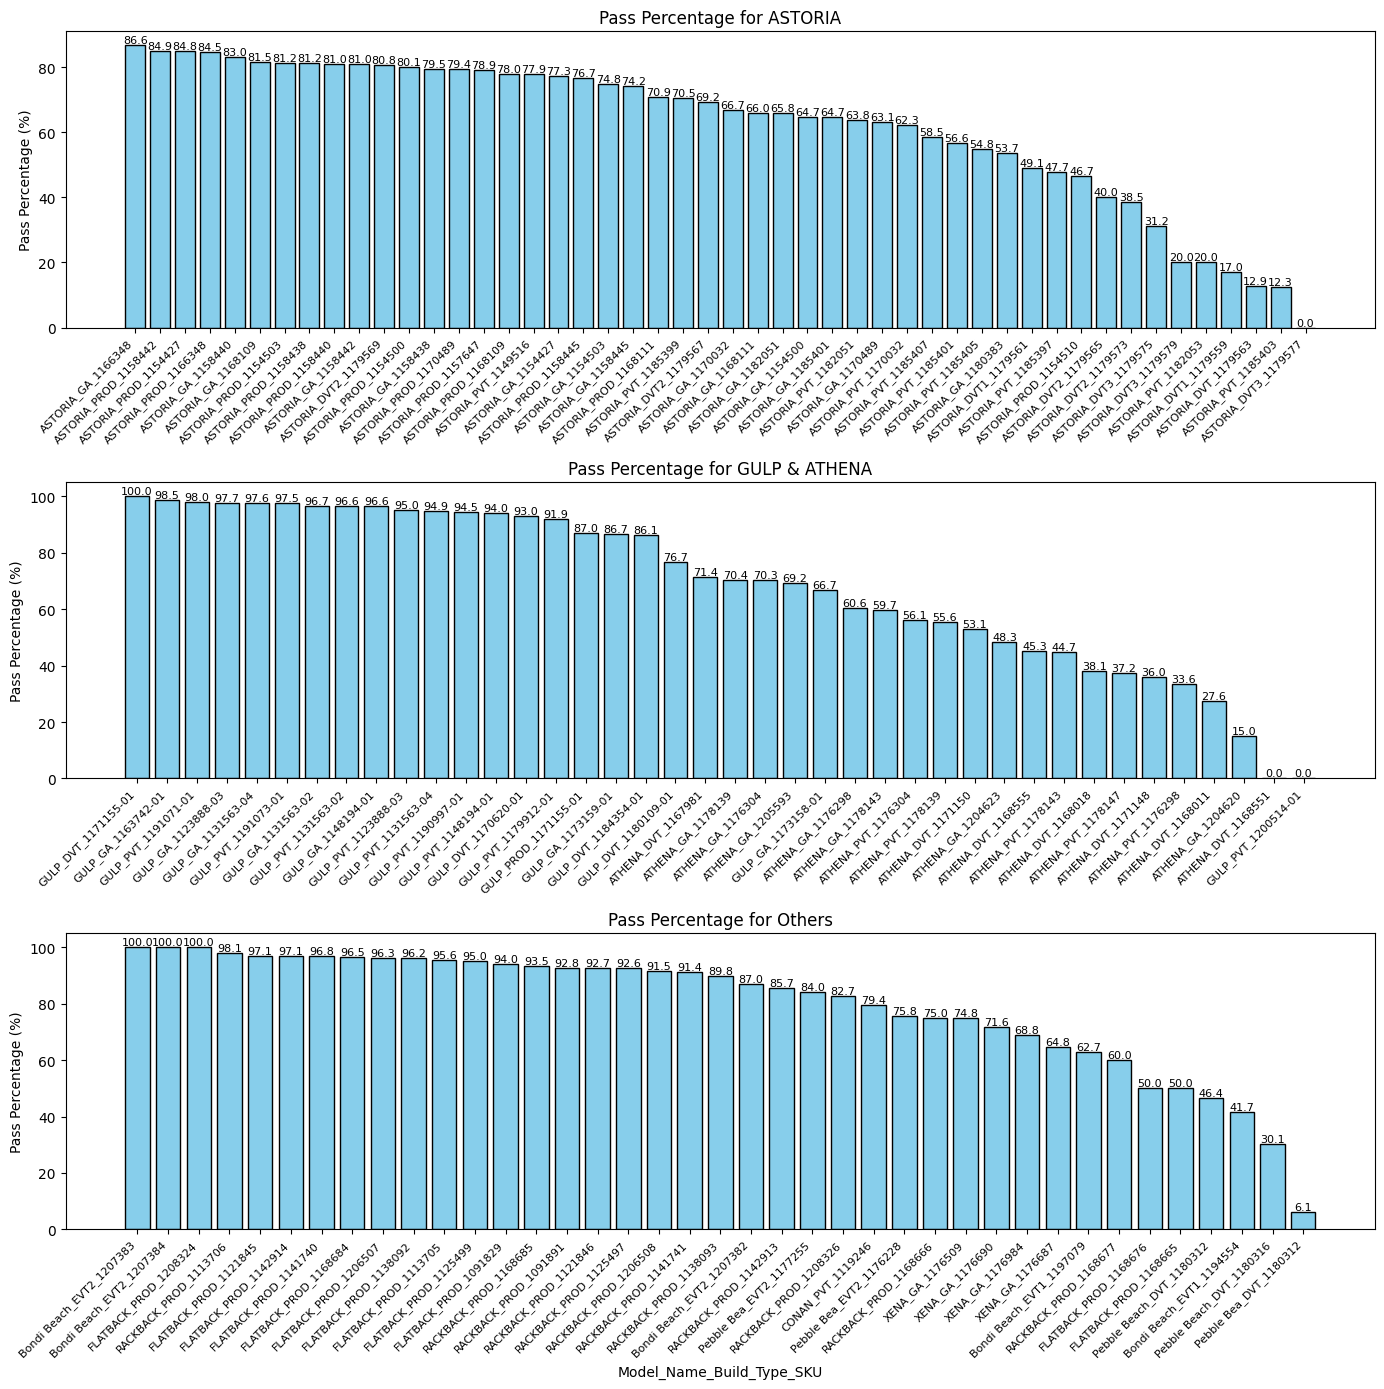

In [ ]:
dq.plot_allpass_percentage(result_df)

# Station-Wise Average Repair Percentage per Product 

In [22]:
# Step 1: Identify serial numbers where ALL test_result = 1 and remove them
valid_sn = df.groupby("serial_number")["test_result"].apply(lambda x: (x != 1).any())
df_filtered = df[df["serial_number"].isin(valid_sn[valid_sn].index)].reset_index(drop=True).sort_values(by=['model_name','build_type', 'skuno','serial_number','station','test_result'], ascending=[True,True,True,True,True,True])
# Step 2: Count total tests per station
total_tests = (
    df_filtered.groupby(["model_name", "build_type", "skuno", "station"])["test_result"]
    .count()
    .reset_index(name="total_tests")
)

# Step 3: Count failed tests (test_result = 0) per station
failed_tests = (
    df_filtered[df_filtered["test_result"] == 0]
    .groupby(["model_name", "build_type", "skuno", "station"])["test_result"]
    .count()
    .reset_index(name="failed_tests")
)

# Step 4: Merge total and failed test counts
failure_percentage_df = total_tests.merge(
    failed_tests, on=["model_name", "build_type", "skuno", "station"], how="left"
)

# Fill NaN values for failed_tests with 0 (stations that had no failures)
failure_percentage_df["failed_tests"] = failure_percentage_df["failed_tests"].fillna(0)

# Step 5: Calculate failure percentage
failure_percentage_df["failure_percentage"] = (
    (failure_percentage_df["failed_tests"] / failure_percentage_df["total_tests"]) * 100
).round(2)

failure_percentage_df = failure_percentage_df.sort_values(by=['model_name','build_type', 'skuno','station','failure_percentage'], ascending=[True,True,True,True,False])
failure_percentage_df = failure_percentage_df[~failure_percentage_df['model_name'].isin(['CONAN', 'Pebble Bea', 'Pebble Beach', 'Bondi Beach'])]



,model_name,build_type,skuno,serial_number,station,test_result
12,ASTORIA,GA,1154427,FWI2401-07655,AST Google Firmware Update Test,1
13,ASTORIA,GA,1154427,FWI2401-07655,AST SDC Test,1
14,ASTORIA,GA,1154427,FWI2401-07655,AST SDC Test,0
15,ASTORIA,GA,1154427,FWI2401-07655,AST Run-in Test,1
16,ASTORIA,GA,1154427,FWI2401-07655,AST Functional Test,1
...,...,...,...,...,...,...
2040219,GULP,PVT,1131563-04,IPBFWI250607439,GULP test,0
2040294,GULP,GA,1123888-03,IPBFWI250702038,GULP test,1
2040295,GULP,GA,1123888-03,IPBFWI250702038,GULP test,0
2040299,GULP,GA,1123888-03,IPBFWI250702141,GULP test,1


c:\Users\Le-Hao.Hsu\OneDrive - Foxconn Industrial Internet in North America\Desktop\Gavin\cims_test\data_query.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Le-Hao.Hsu\OneDrive - Foxconn Industrial Internet in North America\Desktop\Gavin\cims_test\data_query.py:251: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


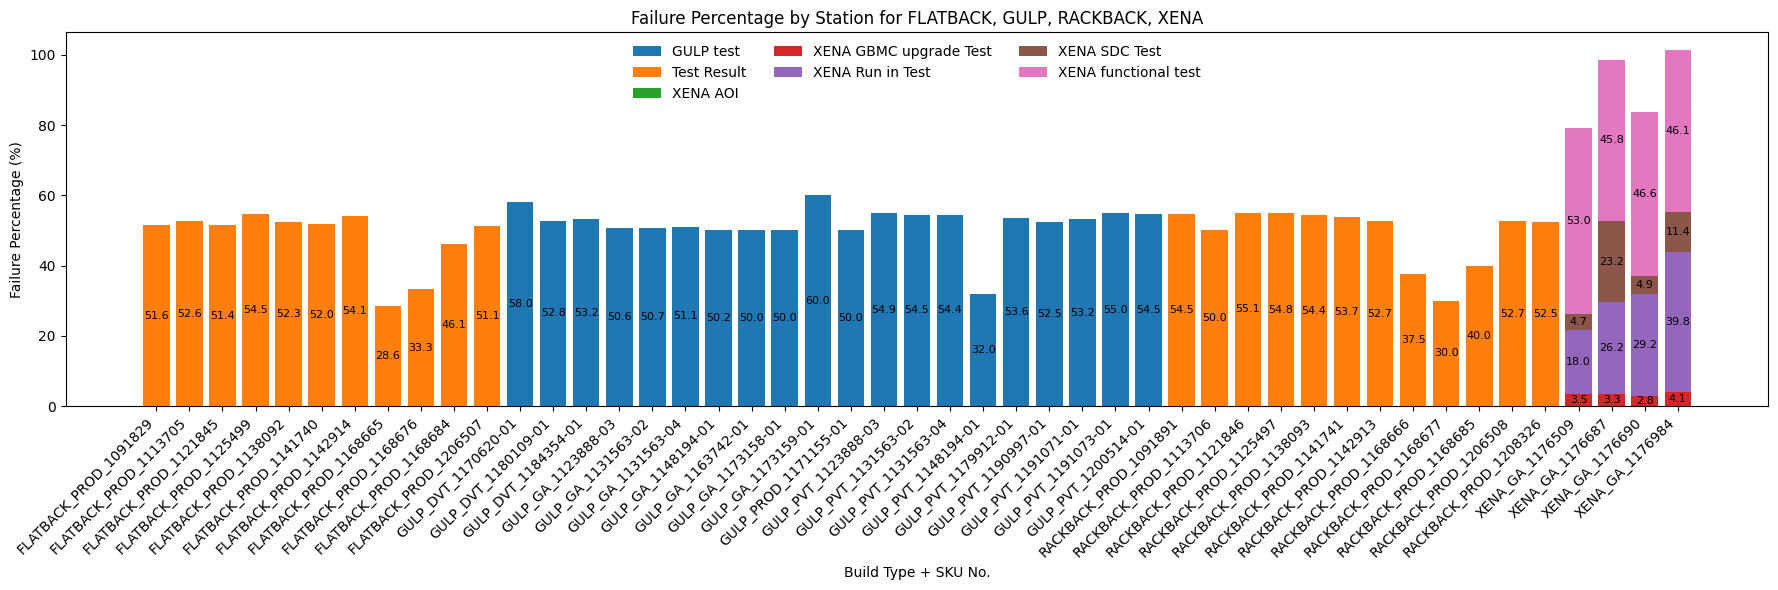

In [94]:
dq.plot_failure_percentage_by_model(failure_percentage_df, ['FLATBACK', 'GULP', 'RACKBACK', 'XENA'])

# Intelligence Table want to do

In [110]:
repair_sn = "'FWI2341-09108'"
idt_df = dq.create_intel_table(repair_sn)
new_idt_df = dq.extract_symptom_info(idt_df)
new_idt_df

,serial_number,model_name,build_type,skuno,station,result,test_start_time,test_end_time,repaired_date,repair_code,repaired_description,symptom_count_dict
0,FWI2341-09108,ASTORIA,GA,1154427,AST--AOI,1,None,2023-10-13 15:15:08,None,None,None,N/A
1,FWI2341-09108,ASTORIA,GA,1154427,AST Functional Test,1,2023-10-13 15:32:18,2023-10-13 17:26:19,None,None,None,N/A
2,FWI2341-09108,ASTORIA,GA,1154427,AST Run-in Test,1,2023-10-13 17:27:11,2023-10-14 03:36:10,None,None,None,N/A
3,FWI2341-09108,ASTORIA,GA,1154427,AST SDC Test,0,2023-10-14 03:40:06,2023-10-14 05:00:31,None,None,None,"{('error-monitor-unknown-error', 'test failed:..."
4,FWI2341-09108,ASTORIA,GA,1154427,AST SDC Test,0,2023-10-17 13:29:23,2023-10-17 14:10:08,None,None,None,"{('no-output-detected', 'either failed to trig..."
5,FWI2341-09108,ASTORIA,GA,1154427,AST SDC Test,0,2023-10-17 14:32:26,2023-10-17 14:55:10,2023-10-17 16:24:10,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs",{('excessive-uncorrectable-cpu-type_core-error...
6,FWI2341-09108,ASTORIA,GA,1154427,AST SDC Test,0,2023-10-17 14:32:26,2023-10-17 14:55:10,2023-10-17 16:24:10,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs",{('excessive-uncorrectable-cpu-type_core-error...
7,FWI2341-09108,ASTORIA,GA,1154427,AST SDC Test,0,2023-10-17 16:25:54,2023-10-17 16:50:17,2023-10-18 08:31:00,REPLACE- DIMM,"Unit show error Locator:P1MK0, replace DIMM13","{('procedural-error', 'hwinterface getnodeinfo..."
8,FWI2341-09108,ASTORIA,GA,1154427,AST Functional Test,1,2023-10-18 08:32:21,2023-10-18 09:47:11,None,None,None,N/A
9,FWI2341-09108,ASTORIA,GA,1154427,AST Run-in Test,1,2023-10-18 09:47:55,2023-10-18 19:08:54,None,None,None,N/A


In [ ]:
import pandas as pd
from collections import Counter

def aggregate_symptom_counts(new_idt_df):
    # Step 1: Filter only rows where result == 0
    filtered_df = new_idt_df[new_idt_df["result"] == 0].copy()

    # Step 2: Aggregate counts of (label, message) pairs
    overall_counter = Counter()
    symptom_info_list = []  # To store metadata

    for _, row in filtered_df.iterrows():
        symptom_count_dict = row["symptom_count_dict"]

        if isinstance(symptom_count_dict, dict):  # Ensure it's valid
            for (label, msg), count in symptom_count_dict.items():
                overall_counter[(label, msg)] += count

                # Store date, code, description, skuno with the symptoms
                symptom_info_list.append({
                    "skuno": row.get("skuno", "NA"),  # Handle missing values
                    "symptom_label": label,
                    "symptom_msg": msg,
                    "count": count,
                    "repaired_date": row.get("repaired_date") if pd.notna(row.get("repaired_date")) else "NA",
                    "repair_code": row.get("repair_code") if pd.notna(row.get("repair_code")) else "NA",
                    "repaired_description": row.get("repaired_description") if pd.notna(row.get("repaired_description")) else "NA"
                })

    # Step 3: Convert to DataFrame
    overall_df = pd.DataFrame(symptom_info_list)

    # Step 4: Aggregate counts by (label, message), summing over duplicates
    aggregated_df = overall_df.groupby(["skuno", "symptom_label", "symptom_msg", "repaired_date", "repair_code", "repaired_description"], as_index=False).agg({"count": "sum"})

    # Step 5: Sort by count (descending) and then by repaired_date (ascending)
    aggregated_df = aggregated_df.sort_values(by=["count", "repaired_date"], ascending=[False, True])

    return aggregated_df

# Example usage
aggregate_symptom_counts(new_idt_df)


,skuno,symptom_label,symptom_msg,repaired_date,repair_code,repaired_description,count
7,1154427,excessive-uncorrectable-cpu-type_core-errors,"cpu1 type_core, error type: uncorrectable-cpu-...",2023-10-17 16:24:10,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs",4
18,1154427,procedural-error,hwinterface getnodeinfo failed: failed to conn...,2023-10-18 08:31:00,REPLACE- DIMM,"Unit show error Locator:P1MK0, replace DIMM13",3
0,1154427,create telnet and ssh connection to dut failed,mobo booting failed.\nlog in ovss fail.,2023-10-17 16:24:10,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs",2
1,1154427,diorite pci string checking,string 'pcibus: discovered pci @ [01|00|00]' n...,2023-10-17 16:24:10,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs",2
2,1154427,diorite sanity check failed,send command '/usr/bin/ipmitool fru' failed.\n...,2023-10-17 16:24:10,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs",2
4,1154427,excessive-uncorrectable-cpu-type_core-errors,"cpu0 type_core, error type: uncorrectable-cpu-...",2023-10-17 16:24:10,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs",2
10,1154427,procedural-error,failed to enumerate eeproms: failed to connect...,2023-10-18 08:31:00,REPLACE- DIMM,"Unit show error Locator:P1MK0, replace DIMM13",2
5,1154427,excessive-uncorrectable-cpu-type_core-errors,"cpu0 type_core, error type: uncorrectable-cpu-...",NA,NA,NA,2
8,1154427,hardware config check failed,send command 'dmidecode -t processor | grep se...,2023-10-18 08:31:00,REPLACE- DIMM,"Unit show error Locator:P1MK0, replace DIMM13",1
11,1154427,procedural-error,failed to get getversion: failed to connect to...,2023-10-18 08:31:00,REPLACE- DIMM,"Unit show error Locator:P1MK0, replace DIMM13",1


In [93]:
from collections import Counter

def count_symptom_pairs(result_df):
    # Step 1: Filter result == 1
    filtered_df = result_df[result_df["result"] == 0].copy()

    pair_counts = Counter()

    for _, row in filtered_df.iterrows():
        symptom_msgs = row["symptom_msg"].split(" | ") if row["symptom_msg"] != "N/A" else []
        symptom_labels = row["symptom_label"].split(" | ") if row["symptom_label"] != "N/A" else []
        print("row")
        print(len(symptom_labels))
        print(len(symptom_msgs))
        # Ensure the number of messages matches the number of labels
        if len(symptom_msgs) == len(symptom_labels):
            pairs = list(zip(symptom_msgs, symptom_labels))
            pair_counts.update(pairs)

    # Convert to DataFrame
    pair_count_df = pd.DataFrame(pair_counts.items(), columns=["symptom_pair", "count"])
    pair_count_df["symptom_msg"] = pair_count_df["symptom_pair"].apply(lambda x: x[0])
    pair_count_df["symptom_label"] = pair_count_df["symptom_pair"].apply(lambda x: x[1])
    pair_count_df = pair_count_df.drop(columns=["symptom_pair"])

    return pair_count_df

symptom_pair_counts = count_symptom_pairs(new_idt_df)
symptom_pair_counts


row
4
4
row
4
5
row
4
5
row
4
5
row
2
12


,count,symptom_msg,symptom_label
0,1,"command 'rsync -s -e ""sshpass -p 0vss ssh -o s...",error-monitor-unknown-error
1,1,diag execution failed.,rsync-error
2,1,task return code: 1.,task-failed-with-non-zero-code-return-code
3,1,test failed: unavailable: connection timed out...,test-completion-missing-error-cpu_checker_burnin


# Symptom Info Matched with Repair and Occurences

In [2]:
repair_sn = "'FWI2341-09108'"
symptom_df = dq.symptom_result(repair_sn)

In [138]:
symptom_df

,serial_number,station,test_start_time,test_end_time,symptom_info,repair_code,repaired_description
0,FWI2341-09108,AST SDC Test,2023-10-14 03:40:06-05:00,2023-10-14 05:00:31-05:00,{'PassSymRunKey_6ff4c363-c3cf-4025-a2f7-a59b81...,None,None
1,FWI2341-09108,AST SDC Test,2023-10-17 13:29:23-05:00,2023-10-17 14:10:08-05:00,{'SymptomRunKey_1dbd78b8-7702-4085-9ab9-425006...,None,None
2,FWI2341-09108,AST SDC Test,2023-10-17 14:32:26-05:00,2023-10-17 14:55:10-05:00,{'SymptomRunKey_4d819d35-69f7-4af3-a7f6-bd01b0...,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs"
3,FWI2341-09108,AST SDC Test,2023-10-17 14:32:26-05:00,2023-10-17 14:55:10-05:00,{'SymptomRunKey_4d819d35-69f7-4af3-a7f6-bd01b0...,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs"
4,FWI2341-09108,AST SDC Test,2023-10-17 16:25:54-05:00,2023-10-17 16:50:17-05:00,{'PassSymRunKey_114c6bdb-67bd-4857-9474-55a5fe...,REPLACE- DIMM,"Unit show error Locator:P1MK0, replace DIMM13"


In [7]:
# Apply function to result_df
symptom_count_df = dq.count_symptom_occurrences_with_repairs(symptom_df)


In [8]:
symptom_count_df

,symptom_msg,symptom_label,occurrence_count,repair_codes,repair_descriptions
0,"CPU1 TYPE_CORE, Error type: uncorrectable-cpu-...",excessive-uncorrectable-cpu-type_core-errors,2,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs"
1,Mobo booting failed.\nLog in OVSS fail.,Create Telnet and SSH connection to DUT failed,2,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs"
2,"CPU0 TYPE_CORE, Error type: uncorrectable-cpu-...",excessive-uncorrectable-cpu-type_core-errors,2,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs"
3,String 'PciBus: Discovered PCI @ [01|00|00]' n...,Diorite PCI string checking,2,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs"
4,Send command '/usr/bin/ipmitool fru' failed.\n...,Diorite Sanity Check Failed,2,RESEAT - CPU,"Unit show error in CPU0 and CPU1, reseat CPUs"
5,Test failed: UNAVAILABLE: Connection timed out...,error-monitor-unknown-error,1,N/A,N/A
6,Diag execution failed.,test-completion-missing-error-cpu_checker_burnin,1,N/A,N/A
7,Task return code: 1.,task-failed-with-non-zero-code-return-code,1,N/A,N/A
8,"Command 'rsync -s -e ""sshpass -p 0vss ssh -o S...",rsync-error,1,N/A,N/A
9,Diag execution failed.,test-completion-missing-error-dna,1,N/A,N/A


# Recommendations Repair Code for Symptoms

In [27]:
repair_sn = "'FWI2401-07724'"
repair_station = "'AST SDC Test'"

repair_df = dq.create_repair_table(repair_sn, repair_station)

In [28]:
symptoms, recommend_repair_df = dq.find_matching_repairs(repair_df, repair_sn)

In [29]:
symptoms

{'excessive-uncorrectable-cache-cpu-errors',
 'rsync-error',
 'test-completion-missing-error-amd_cpu_power_virus',
 'test-completion-missing-error-maxcorestim'}

In [30]:
recommend_repair_df

,model_name,build_type,skuno,station,serial_number,repair_detail_created_at,repair_code,result,symptom_labels
0,ASTORIA,GA,1154427,AST SDC Test,FWI2341-09108,None,None,0,error-monitor-unknown-error|rsync-error|task-f...
1,ASTORIA,GA,1154427,AST SDC Test,FWI2341-09108,None,None,0,excessive-uncorrectable-cpu-type_core-errors|n...
2,ASTORIA,GA,1154427,AST SDC Test,FWI2341-09108,2023-10-17 16:23:01,RESEAT - CPU,0,create telnet and ssh connection to dut failed...
3,ASTORIA,GA,1154427,AST SDC Test,FWI2341-09108,2023-10-17 16:24:10,RESEAT - CPU,0,create telnet and ssh connection to dut failed...
4,ASTORIA,GA,1154427,AST SDC Test,FWI2341-09108,2023-10-18 08:31:00,REPLACE- DIMM,0,hardware config check failed|procedural-error
...,...,...,...,...,...,...,...,...,...
26246,ASTORIA,GA,1154427,AST SDC Test,FWI2507-13832,None,None,1,None
26256,ASTORIA,GA,1154427,AST SDC Test,FWI2507-13839,2025-02-20 04:08:02,SDC_RETEST,0,check boot number failed|no-output-detected|rs...
26257,ASTORIA,GA,1154427,AST SDC Test,FWI2507-13839,None,None,1,None
26459,ASTORIA,GA,1154427,AST SDC Test,FWI2507-14037,2025-02-20 23:55:35,SDC_RETEST,0,rsync-error|test-completion-missing-error-rainbow
